# 1. Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor
import optuna
import category_encoders as ce
from collections import defaultdict
from tqdm import tqdm
from scipy.stats import mode

import warnings

# 2. Import Datasets

## 2.1. Load datasets

In [2]:
# Retrieve datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_data = pd.read_csv('sample_submission.csv')
original_data = pd.read_csv('horse.csv')

### Surgery
1. 1 = Yes, it had surgery
2. 2 = It was treated without surgery

### Age
1. 1 = Adult horse
2. 2 = Young (< 6 months)

### Hospital Number
- Numeric ID - the case number assigned to the horse (may not be unique if the horse is treated more than once)

### Rectal Temperature
- Linear - in degrees Celsius.
  1. An elevated temperature may occur due to infection.
  2. Temperature may be reduced when the animal is in late shock.
  3. Normal temperature is 37.8°C.
  4. This parameter will usually change as the problem progresses, e.g., may start out normal, then become elevated because of the lesion, passing back through the normal range as the horse goes into shock.

### Pulse
- Linear - the heart rate in beats per minute.
  1. 30-40 is normal for adults.
  2. Rare to have a lower than normal rate, although athletic horses may have a rate of 20-25.
  3. Animals with painful lesions or suffering from circulatory shock may have an elevated heart rate.

### Respiratory Rate
- Linear - normal rate is 8 to 10.
  1. Usefulness is doubtful due to significant fluctuations.

### Temperature of Extremities
- A subjective indication of peripheral circulation.
  1. Possible values:
     - 1 = Normal
     - 2 = Warm
     - 3 = Cool
     - 4 = Cold
  2. Cool to cold extremities indicate possible shock.
  3. Hot extremities should correlate with an elevated rectal temperature.

### Peripheral Pulse
- Subjective.
  1. Possible values:
     - 1 = Normal
     - 2 = Increased
     - 3 = Reduced
     - 4 = Absent
  2. Normal or increased peripheral pulse indicates adequate circulation, while reduced or absent indicate poor perfusion.

### Mucous Membrane
- A subjective measurement of color.
  1. Possible values:
     - 1 = Normal pink
     - 2 = Bright pink
     - 3 = Pale pink
     - 4 = Pale cyanotic
     - 5 = Bright red/injected
     - 6 = Dark cyanotic
  2. 1 and 2 probably indicate normal or slightly increased circulation.
  3. 3 may occur in early shock.
  4. 4 and 6 indicate serious circulatory compromise.
  5. 5 is more indicative of septicemia.

### Capillary Refill Time
- A clinical judgment.
  1. The longer the refill, the poorer the circulation.
  2. Possible values:
     - 1 = < 3 seconds
     - 2 = >= 3 seconds

### Pain
- Possible values:
  1. 1 = Alert, no pain
  2. 2 = Depressed
  3. 3 = Intermittent mild pain
  4. 4 = Intermittent severe pain
  5. 5 = Continuous severe pain
- Should NOT be treated as an ordered or discrete variable.
- Generally, the more painful, the more likely it is to require surgery.
- Prior treatment of pain may mask the pain level to some extent.

### Peristalsis
- An indication of the activity in the horse's gut.
  1. Possible values:
     - 1 = Hypermotile
     - 2 = Normal
     - 3 = Hypomotile
     - 4 = Absent

### Abdominal Distention
- An IMPORTANT parameter.
  1. Possible values:
     - 1 = None
     - 2 = Slight
     - 3 = Moderate
     - 4 = Severe
  2. An animal with abdominal distension is likely to be painful and have reduced gut motility.
  3. A horse with severe abdominal distension is likely to require surgery just to relieve the pressure.

### Nasogastric Tube
- Refers to any gas coming out of the tube.
  1. Possible values:
     - 1 = None
     - 2 = Slight
     - 3 = Significant
  2. A large gas cap in the stomach is likely to give the horse discomfort.

### Nasogastric Reflux
- Possible values:
  1. 1 = None
  2. 2 = > 1 liter
  3. 3 = < 1 liter
- The greater amount of reflux, the more likelihood of serious obstruction to fluid passage from the rest of the intestine.

### Nasogastric Reflux pH
- Linear - scale is from 0 to 14 with 7 being neutral.
  1. Normal values are in the 3 to 4 range.

### Rectal Exam Feces
- Possible values:
  1. 1 = Normal
  2. 2 = Increased
  3. 3 = Decreased
  4. 4 = Absent
- Absent feces probably indicate an obstruction.

### Abdomen
- Possible values:
  1. 1 = Normal
  2. 2 = Other
  3. 3 = Firm feces in the large intestine
  4. 4 = Distended small intestine
  5. 5 = Distended large intestine
- 3 is probably an obstruction caused by mechanical impaction and is normally treated medically.
- 4 and 5 indicate a surgical lesion.

### Packed Cell Volume
- Linear - the number of red cells by volume in the blood.
  1. Normal range is 30 to 50.
  2. The level rises as circulation becomes compromised or as the animal becomes dehydrated.

### Total Protein
- Linear - normal values lie in the 6-7.5 g/dL range.
  1. The higher the value, the greater the dehydration.

### Abdominal Appearance
- A needle is put in the horse's abdomen, and fluid is obtained from the abdominal cavity.
  1. Possible values:
     - 1 = Clear
     - 2 = Cloudy
     - 3 = Serosanguinous
  2. Normal fluid is clear, while cloudy or serosanguinous indicates a compromised gut.

### Abdominal Protein
- Linear - the higher the level of protein, the more likely it is to have a compromised gut.
  1. Values are in g/dL.

### Outcome
- What eventually happened to the horse?
  1. Possible values:
     - 1 = Lived
     - 2 = Died
     - 3 = Was euthanized

### Surgical Lesion
- Retrospectively, was the problem (lesion) surgical?
  1. All cases are either operated upon or autopsied, so this value and the lesion type are always known.
  2. Possible values:
     - 1 = Yes
     - 2 = No

### Lesion 1
- First number is the site of lesion:
  1. 1 = Gastric
  2. 2 = Small intestine
  3. 3 = Large colon
  4. 4 = Large colon and cecum
  5. 5 = Cecum
  6. 6 = Transverse colon
  7. 7 = Rectum/descending colon
  8. 8 = Uterus
  9. 9 = Bladder
  10. 11 = All intestinal sites
  11. 00 = None

### Lesion 2
- Second number is the type:
  1. 1 = Simple
  2. 2 = Strangulation
  3. 3 = Inflammation
  4. 4 = Other

### Lesion 3
- Third number is the subtype:
  1. 1 = Mechanical
  2. 2 = Paralytic
  3. 0 = N/A
- Fourth number is the specific code:
  1. 1 = Obstruction
  2. 2 = Intrinsic
  3. 3 = Extrinsic
  4. 4 = Adynamic
  5. 5 = Volvulus/torsion
  6. 6 = Intussusception
  7. 7 = Thromboembolic
  8. 8 = Hernia
  9. 9 = Lipoma/splenic incarceration
  10. 10 = Displacement
  11. 0 = N/A

### CP Data
- Is pathology data present for this case?
  1. 1 = Yes
  2. 2 = No

In [3]:
# View the training data
train_data.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [4]:
# View the test data
test_data.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,...,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1,1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,...,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
2,1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,...,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
3,1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,...,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
4,1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,...,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes


In [5]:
# View the sample data
sample_data.head()

,id,outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,euthanized
4,1239,lived


In [6]:
# View the original data
original_data.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


## 2.2. Prepare datasets

In [7]:
# Create a new categorical feature 'synthetic' to indicate if a data is synthetic or real
train_data['synthetic'] = pd.Series(True, index=train_data.index).astype(object)
train_data.insert(len(train_data.columns) - 2, 'synthetic', train_data.pop('synthetic'))

original_data['synthetic'] = pd.Series(False, index=original_data.index).astype(object)
original_data.insert(len(original_data.columns) - 2, 'synthetic', original_data.pop('synthetic'))

test_data['synthetic'] = pd.Series(True, index=test_data.index).astype(object)


In [8]:
# Combine the datasets of test data and sample data for analysis later
test_data = pd.merge(test_data, sample_data, on='id', how='inner')
test_data.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,synthetic,outcome
0,1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,...,7.5,clear,2.3,no,0,0,0,no,True,lived
1,1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,...,6.0,serosanguious,2.6,no,2208,0,0,yes,True,died
2,1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,...,6.0,cloudy,1.6,yes,2205,0,0,yes,True,lived
3,1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,...,81.0,NaN,1.0,yes,1400,0,0,no,True,euthanized
4,1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,...,6.8,cloudy,2.6,yes,2208,0,0,yes,True,lived


In [9]:
# Remove the column 'id' due to its irrelevance
train_data=train_data.drop("id",axis=1)
test_data=test_data.drop("id",axis=1)

In [10]:
# Combine the datasets of training data and original data
train_data_new=pd.concat([train_data, original_data], ignore_index=True)
train_data_new.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,synthetic,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,8.5,serosanguious,3.4,yes,2209,0,0,no,True,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,64.0,serosanguious,2.0,yes,2208,0,0,no,True,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,6.4,serosanguious,3.4,yes,5124,0,0,no,True,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,7.0,cloudy,3.9,yes,2208,0,0,yes,True,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,7.3,cloudy,2.6,no,0,0,0,yes,True,lived


# 3. Analyzing Datasets

## 3.1. Observe datasets

In [11]:
# Observe the information of the data
train_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1534 non-null   object 
 1   age                    1534 non-null   object 
 2   hospital_number        1534 non-null   int64  
 3   rectal_temp            1474 non-null   float64
 4   pulse                  1510 non-null   float64
 5   respiratory_rate       1476 non-null   float64
 6   temp_of_extremities    1439 non-null   object 
 7   peripheral_pulse       1405 non-null   object 
 8   mucous_membrane        1466 non-null   object 
 9   capillary_refill_time  1496 non-null   object 
 10  pain                   1435 non-null   object 
 11  peristalsis            1470 non-null   object 
 12  abdominal_distention   1455 non-null   object 
 13  nasogastric_tube       1350 non-null   object 
 14  nasogastric_reflux     1407 non-null   object 
 15  naso

In [12]:
# Process data
train_data_new.describe().T

,count,mean,std,min,25%,50%,75%,max
hospital_number,1534.0,980469.409387,1.392849e+06,518476.0,528806.0,529840.0,534259.25,5305629.0
rectal_temp,1474.0,38.196744,7.798830e-01,35.4,37.8,38.2,38.60,40.8
pulse,1510.0,78.194702,2.916252e+01,30.0,52.0,72.0,96.00,184.0
respiratory_rate,1476.0,30.120596,1.665080e+01,8.0,18.0,28.0,36.00,96.0
nasogastric_reflux_ph,1288.0,4.395963,1.939516e+00,1.0,2.0,4.5,6.20,7.5
packed_cell_volume,1505.0,49.011296,1.059043e+01,23.0,42.0,48.0,55.00,75.0
total_protein,1501.0,21.899534,2.681306e+01,3.3,6.6,7.5,13.00,89.0
abdomo_protein,1336.0,3.271931,1.621415e+00,0.1,2.0,3.0,4.30,10.1
lesion_1,1534.0,3798.817471,5.429908e+03,0.0,2124.0,2209.0,3205.00,41110.0
lesion_2,1534.0,29.409387,3.367483e+02,0.0,0.0,0.0,0.00,7111.0


In [3]:
# Function to return the list of numerical features from a dataset
def get_num_features(data):
    numeric_features = []
    for col in data.columns:
        if data[col].dtype != object and data[col].dtype != 'category':
            numeric_features.append(col)
    return numeric_features

# Function to return the list of categorical features from a dataset
def get_cat_features(data):
    categorical_features = []
    for col in data.columns:
        if data[col].dtype == object or data[col].dtype == 'category':
            categorical_features.append(col)
    return categorical_features

In [14]:
# Construct the lists of numerical and categorical features
train_num_features = get_num_features(train_data_new)
train_cat_features = get_cat_features(train_data_new)

In [15]:
# View the lists of numerical and categorical features
print(train_num_features)
print(train_cat_features)

['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']
['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'synthetic', 'outcome']


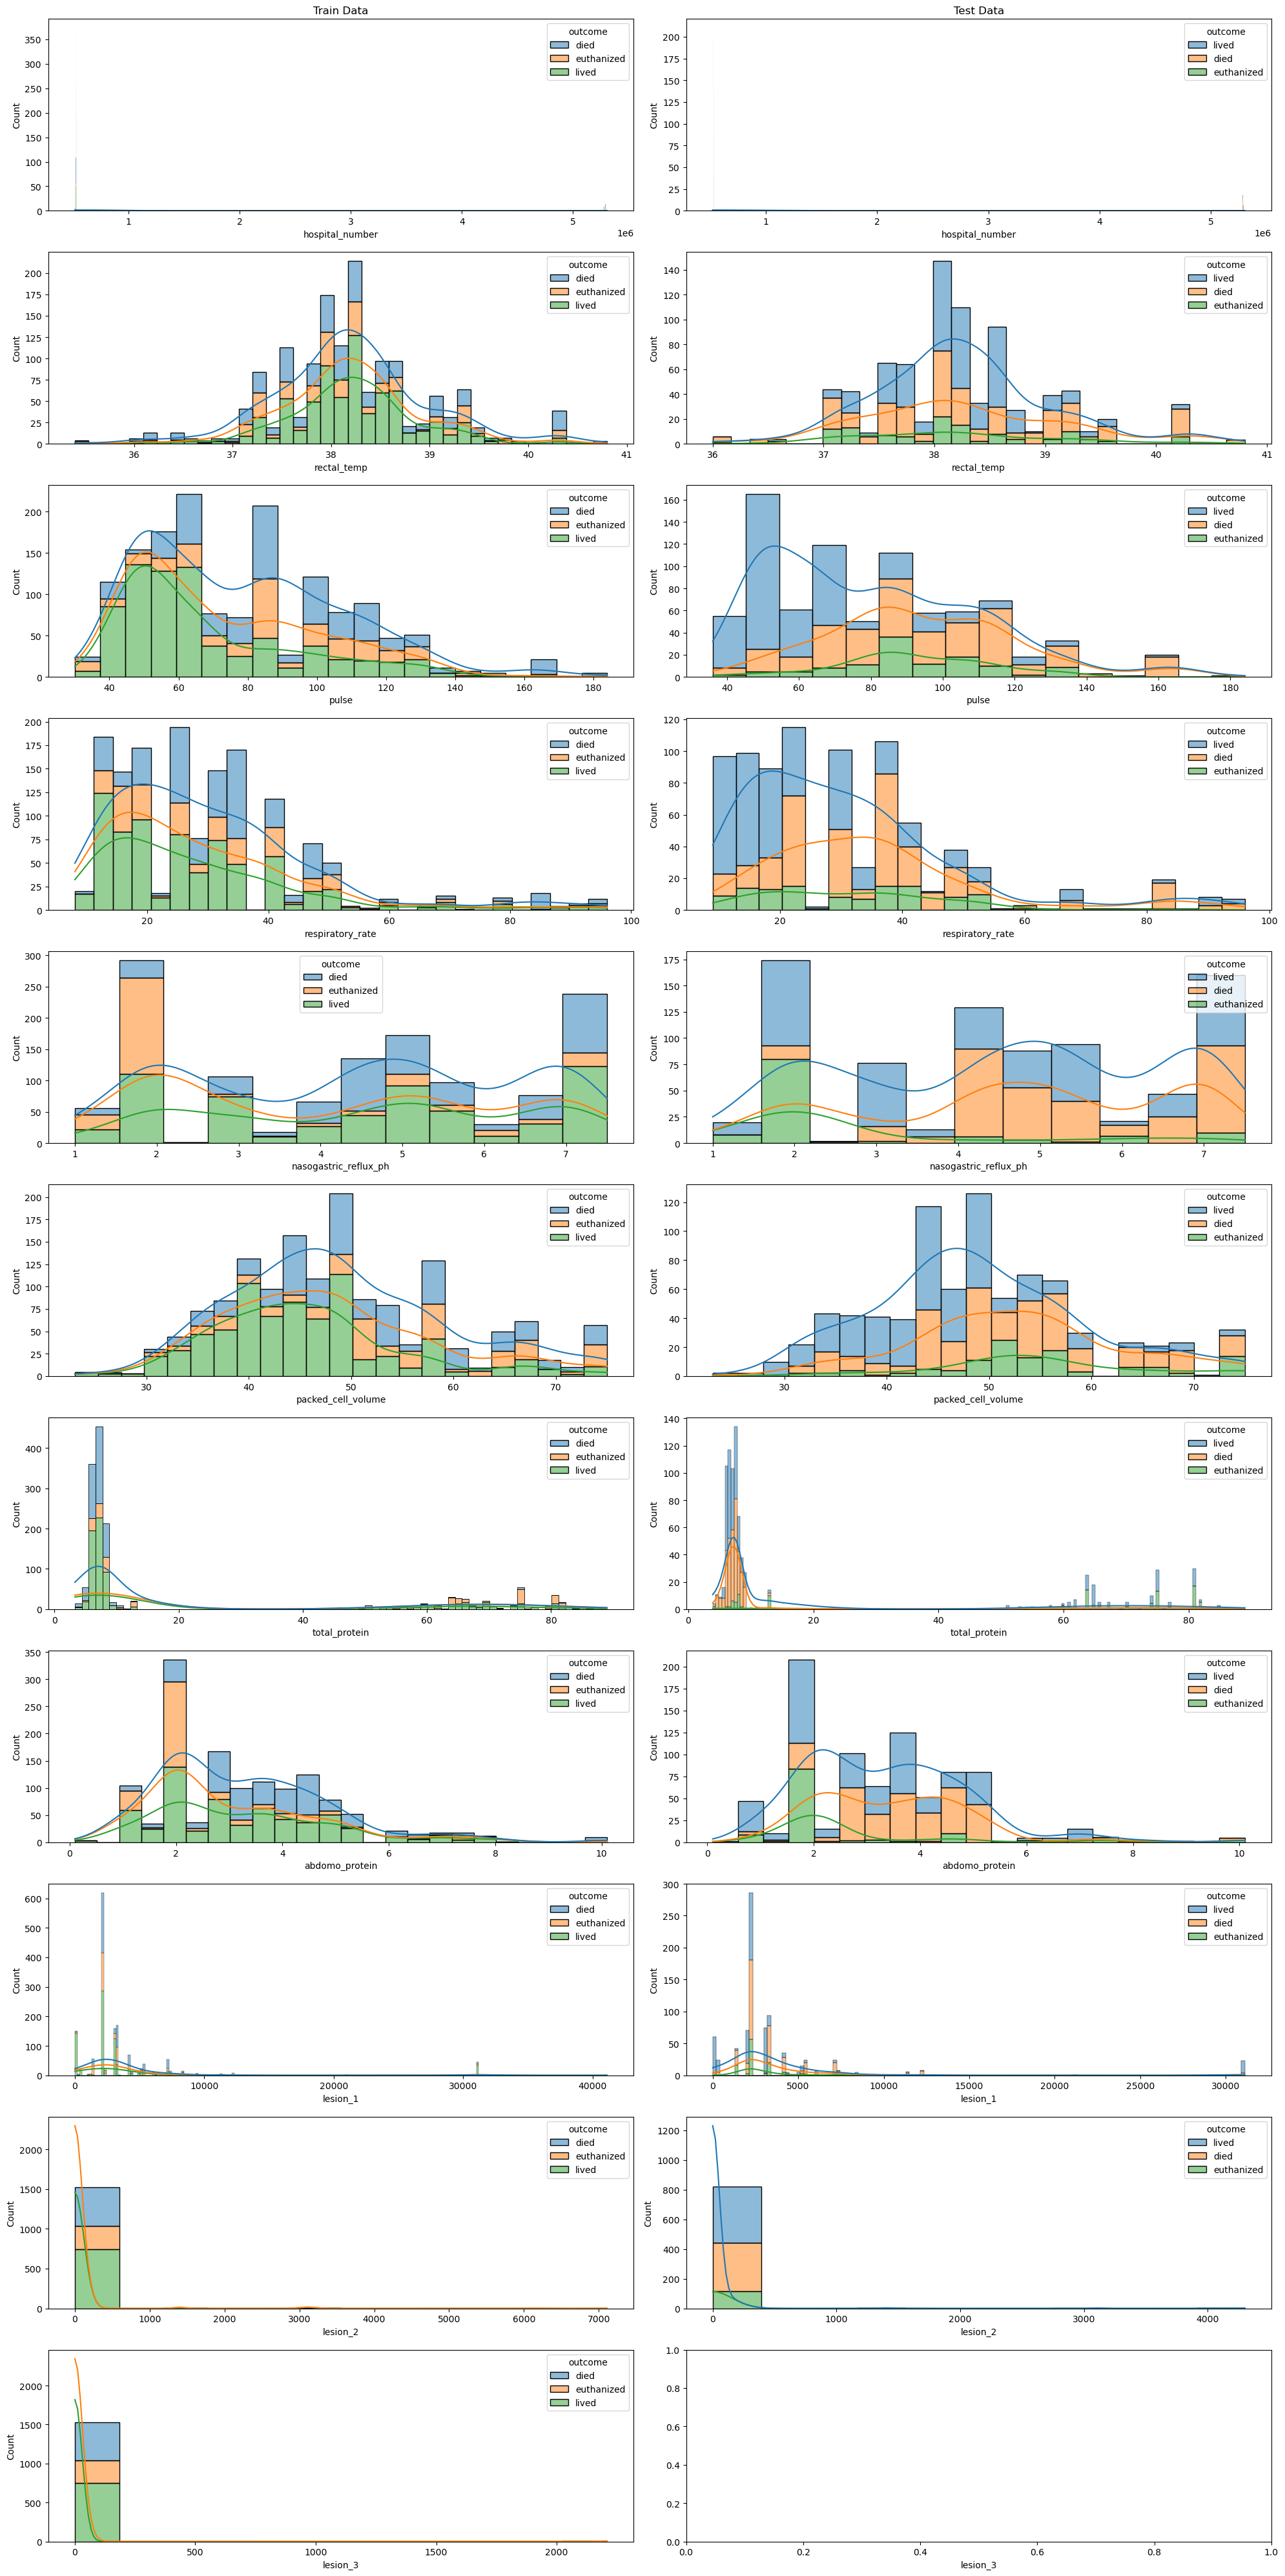

In [16]:
# Plot the distribution of numeric features
def has_only_zeros(column):
    return (column == 0).all()

fig, axs = plt.subplots(len(train_num_features), 2, figsize=(20, 40))

for i, col in enumerate(train_num_features):
    # Plot for train_data_new
    if not has_only_zeros(train_data_new[col]):
        sns.histplot(data=train_data_new, x=col, hue='outcome', kde=True, multiple='stack', ax=axs[i, 0])
    else:
        axs[i, 0].set_xlabel(col)

    # Plot for test_data
    if not has_only_zeros(test_data[col]):
        sns.histplot(data=test_data, x=col, hue='outcome', kde=True, multiple='stack', ax=axs[i, 1])
    else:
        axs[i, 1].set_xlabel(col)

    axs[0][0].set_title('Train Data')
    axs[0][1].set_title('Test Data')

plt.tight_layout()
plt.show()

We note that:
1. The Test Data only consists of 'lived' outcome
2. The feature 'lesion_3' in Test Data only consists of 0s
3. The feature 'hospital_number' should be a categorical feature.

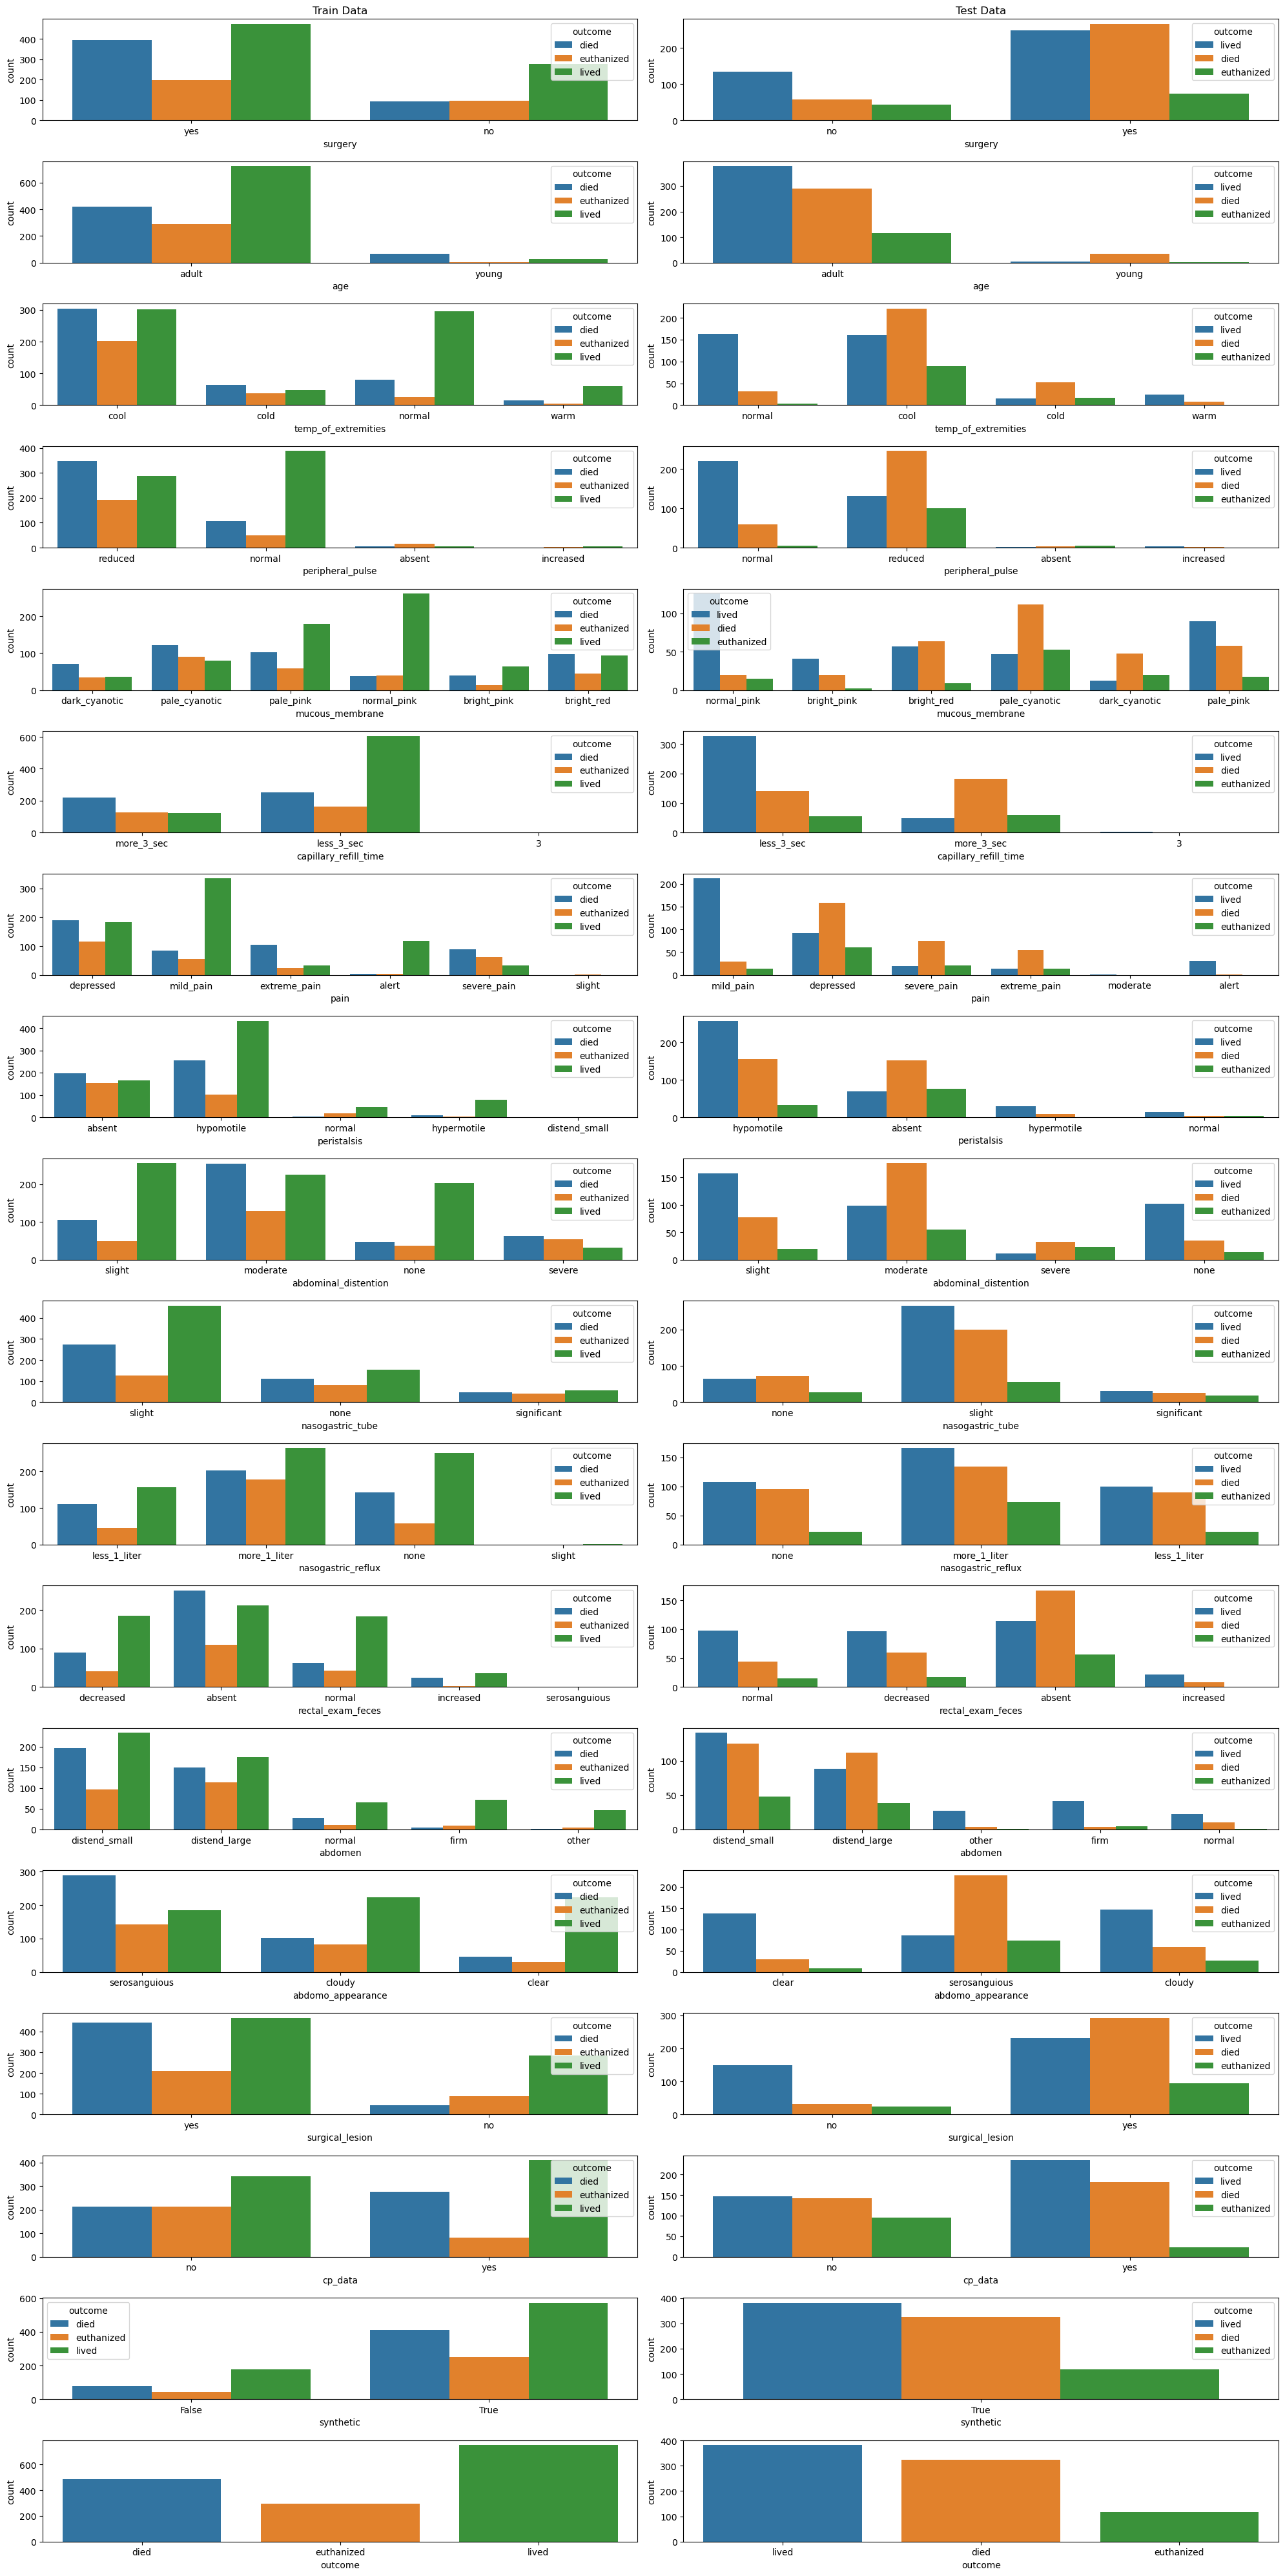

In [17]:
# Plot the distribution of categorical features
num_cols = 2
num_rows = len(train_cat_features)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 40))

for i, col in enumerate(train_cat_features):
    # Plot for train_data_new
    sns.countplot(data=train_data_new, x=col, hue='outcome', ax=axs[i, 0])

    # Plot for test_data
    sns.countplot(data=test_data, x=col, hue='outcome', ax=axs[i, 1])

    axs[0][0].set_title('Train Data')
    axs[0][1].set_title('Test Data')

plt.tight_layout()
plt.show()

We note that: 
1. The categories 'slight' and 'moderate' under feature 'pain', are unique to Train Data and Test Data respectively
2. The category 'distend_small' under feature 'peristalsis' is unique to Train Data
3. The category 'slight' under feature 'nasogastric_discharge' is unique to Train Data
4. The category 'serosanguious' under feature 'rectal_exam_feces' is unique to Train Data
5. The Test Data only consists of 'lived' outcome, as mentioned previously
6. The Test Data only consists of synthetic data

In [18]:
# Remove 'outcome' column in test data since its no longer needed
test_data = test_data.drop('outcome', axis=1)

## 3.2. Check for duplicate data

In [19]:
# Check for duplicate data in train_data_new
train_data_new[train_data_new.duplicated(keep=False)]

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,synthetic,outcome


In [20]:
# Check for duplicate data in test_data
test_data[test_data.duplicated(keep=False)]

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,synthetic


## 3.3. Check for missing data

In [21]:
# Check for missing data in train_data_new
train_data_new.isnull().sum()

surgery                    0
age                        0
hospital_number            0
rectal_temp               60
pulse                     24
respiratory_rate          58
temp_of_extremities       95
peripheral_pulse         129
mucous_membrane           68
capillary_refill_time     38
pain                      99
peristalsis               64
abdominal_distention      79
nasogastric_tube         184
nasogastric_reflux       127
nasogastric_reflux_ph    246
rectal_exam_feces        292
abdomen                  331
packed_cell_volume        29
total_protein             33
abdomo_appearance        213
abdomo_protein           198
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
synthetic                  0
outcome                    0
dtype: int64

In [22]:
# Check for missing data in test_data
test_data.isnull().sum()

surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       35
peripheral_pulse          47
mucous_membrane           13
capillary_refill_time      6
pain                      29
peristalsis               19
abdominal_distention      22
nasogastric_tube          64
nasogastric_reflux        14
nasogastric_reflux_ph      0
rectal_exam_feces        125
abdomen                  154
packed_cell_volume         0
total_protein              0
abdomo_appearance         31
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
synthetic                  0
dtype: int64

In [23]:
# Function to generate additional statistics of features
def construct_features(data):
    feature_table = pd.DataFrame(index=data.columns)
    feature_table['nunique'] = data.nunique()
    feature_table['count'] = data.count()
    feature_table['naCount'] = data.isna().sum()
    feature_table['%OfNa'] = feature_table['naCount'] / (feature_table['naCount'] + feature_table['count'])
    feature_table['dtype'] = data.dtypes
    
    feature_table = pd.concat([feature_table, data.describe().T], axis=1, join='outer')
    return feature_table

In [24]:
# View features of training data
train_statistics = construct_features(train_data_new)
train_statistics

,nunique,count,naCount,%OfNa,dtype,count,mean,std,min,25%,50%,75%,max
surgery,2,1534,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,2,1534,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_number,288,1534,0,0.000000,int64,1534.0,980469.409387,1.392849e+06,518476.0,528806.0,529840.0,534259.25,5305629.0
rectal_temp,43,1474,60,0.039113,float64,1474.0,38.196744,7.798830e-01,35.4,37.8,38.2,38.60,40.8
pulse,52,1510,24,0.015645,float64,1510.0,78.194702,2.916252e+01,30.0,52.0,72.0,96.00,184.0
respiratory_rate,40,1476,58,0.037810,float64,1476.0,30.120596,1.665080e+01,8.0,18.0,28.0,36.00,96.0
temp_of_extremities,4,1439,95,0.061930,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,4,1405,129,0.084094,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,6,1466,68,0.044329,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,3,1496,38,0.024772,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# View features of training data
test_statistics = construct_features(test_data)
test_statistics

,nunique,count,naCount,%OfNa,dtype,count,mean,std,min,25%,50%,75%,max
surgery,2,824,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,2,824,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_number,210,824,0,0.000000,int64,824.0,1.108357e+06,1.555627e+06,521399.0,528743.0,529808.5,534644.0,5305129.0
rectal_temp,34,824,0,0.000000,float64,824.0,3.824454e+01,7.852339e-01,36.0,37.8,38.2,38.6,40.8
pulse,49,824,0,0.000000,float64,824.0,8.022937e+01,2.916471e+01,36.0,54.0,76.0,100.0,184.0
respiratory_rate,38,824,0,0.000000,float64,824.0,3.071966e+01,1.743191e+01,9.0,18.0,28.0,36.0,96.0
temp_of_extremities,4,789,35,0.042476,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,4,777,47,0.057039,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,6,811,13,0.015777,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,3,818,6,0.007282,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Compare unique values of test and train data
features_combined_cat_unique = pd.merge(train_statistics[train_statistics['dtype'] == 'object'], test_statistics[test_statistics['dtype'] == 'object'], left_index=True, right_index=True, suffixes=('.train', '.test'))[['nunique.train', 'nunique.test']]
features_combined_cat_unique[features_combined_cat_unique['nunique.train'] > 2]

,nunique.train,nunique.test
temp_of_extremities,4,4
peripheral_pulse,4,4
mucous_membrane,6,6
capillary_refill_time,3,3
pain,6,6
peristalsis,5,4
abdominal_distention,4,4
nasogastric_tube,3,3
nasogastric_reflux,4,3
rectal_exam_feces,5,4


# 4. Data Preprocessing:

Problems we need to address
1. Missing unique values for categorical features.
2. Missing values (na) for features.

Other things to take note of
1. The Test Data only consists of 'lived' outcome and is synthetic - nothing much we can do now
2. The feature 'lesion_3' in Test Data only consists of 0s
3. The feature 'hospital_number' should be a categorical feature.

## 4.1. Handle missing values

### 4.1.1. Resolve missing feature categories in Train/Test Data

In [27]:
# Find missing feature categories in training and test data
for col in train_cat_features[:-2]:  # Remove 'outcome' and 'generated' columns
    train_values = set(train_data_new[col].unique())
    test_values = set(test_data[col].unique())

    # Print missing feature categories
    if train_values != test_values:
        conflict_values = train_values ^ test_values
        print(f'Feature "{col}": \n \t',  conflict_values, '\n')

Feature "pain": 
 	 {'moderate', 'slight'} 

Feature "peristalsis": 
 	 {'distend_small'} 

Feature "nasogastric_reflux": 
 	 {'slight'} 

Feature "rectal_exam_feces": 
 	 {'serosanguious'} 



In [28]:
# Resolve missing feature categories
train_data_new['pain'] = train_data_new['pain'].replace('slight','mild_pain')       # I just chose this arbitaririly. The number of records having these 2 pain features are low, so we could also consider removing them entirely.
test_data['pain'] = test_data['pain'].replace('moderate','mild_pain')

train_data_new['peristalsis'] = train_data_new['peristalsis'].replace('distend_small', np.nan)

train_data_new['nasogastric_reflux'] = train_data_new['nasogastric_reflux'].replace('slight','less_1_liter')

train_data_new['rectal_exam_feces'] = train_data_new['rectal_exam_feces'].replace('serosanguious', np.nan)

### 4.1.2. Resolve rows with missing values
We will use a combination of removing records with multiple missing values and imputation to resolve the missing data

Text(0.5, 1.0, 'Distribution of na per record in training data')

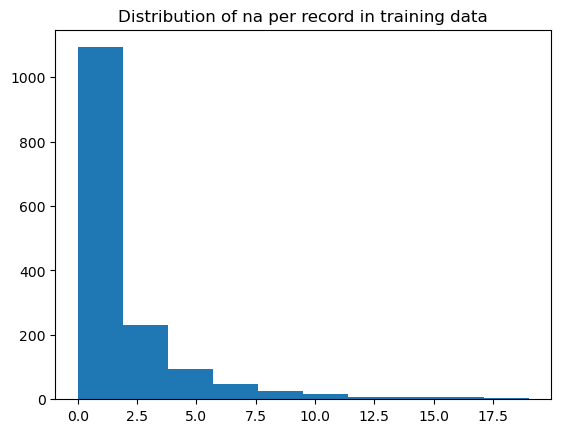

In [29]:
plt.hist(train_data_new.isna().sum(axis=1))
plt.title('Distribution of na per record in training data')

Text(0.5, 1.0, 'Distribution of na per record in test data')

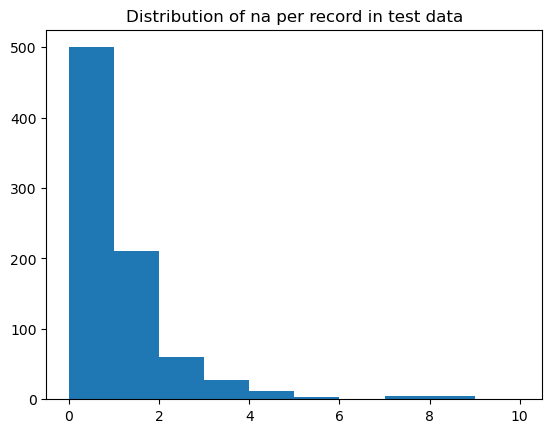

In [30]:
plt.hist(test_data.isna().sum(axis=1))
plt.title('Distribution of na per record in test data')

In [31]:
# View the distribution of na per record of training data
missing_counts = train_data_new.isna().sum(axis=1)
percentiles = [25, 50, 75, 90, 95, 97.5, 99.5]

percentile_values = {q: np.percentile(missing_counts, q) for q in percentiles}
pd.DataFrame(list(percentile_values.items()), columns=['Percentile', 'NaN per record'])

,Percentile,NaN per record
0,25.0,0.000
1,50.0,0.000
2,75.0,2.000
3,90.0,5.000
4,95.0,7.000
5,97.5,10.000
6,99.5,16.335


In [32]:
# Arbitary choice to choose the 97.5 percentile - remove records with 10 or more na values
train_data_new = train_data_new[train_data_new.isna().sum(axis=1) <= 10]
train_data_new=train_data_new.reset_index(drop=True)
train_data_new

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,synthetic,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,8.5,serosanguious,3.4,yes,2209,0,0,no,True,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,64.0,serosanguious,2.0,yes,2208,0,0,no,True,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,6.4,serosanguious,3.4,yes,5124,0,0,no,True,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,7.0,cloudy,3.9,yes,2208,0,0,yes,True,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,7.3,cloudy,2.6,no,0,0,0,yes,True,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,yes,adult,533886,NaN,120.0,70.0,cold,NaN,pale_cyanotic,more_3_sec,...,65.0,NaN,NaN,no,3205,0,0,no,False,euthanized
1499,no,adult,527702,37.2,72.0,24.0,cool,increased,pale_cyanotic,more_3_sec,...,NaN,serosanguious,3.3,yes,2208,0,0,yes,False,euthanized
1500,yes,adult,529386,37.5,72.0,30.0,cold,reduced,pale_cyanotic,less_3_sec,...,6.8,NaN,NaN,yes,3205,0,0,no,False,died
1501,yes,adult,530612,36.5,100.0,24.0,cool,reduced,pale_pink,less_3_sec,...,6.0,serosanguious,3.4,yes,2208,0,0,yes,False,lived


## 4.2. Modifying features

### 4.2.1. Change 'hospital_number' to a categorical feature

In [ ]:
# # Change hospital_number to object type
# train_data_new.loc[:,'hospital_number'] = train_data_new['hospital_number'].astype('object')
# test_data.loc[:,'hospital_number'] = test_data['hospital_number'].astype('object')

# construct_features(test_data)

C:\Users\Ryzen\AppData\Local\Temp\ipykernel_18372\1736492026.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[530001 533836 529812 ... 529386 530612 534618]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_new.loc[:,'hospital_number'] = train_data_new['hospital_number'].astype('object')
C:\Users\Ryzen\AppData\Local\Temp\ipykernel_18372\1736492026.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[534053 528469 528178 534784 529840 530239 528548 528503 5287179 527563
 521399 528548 533836 529461 530402 528641 5290482 529386 527365 528469
 5294369 535085 529399 528931 529388 534145 5297379 535043 528523 529493
 534787 5299603 527563 530254 5299603 530276 527916 534787 529888 533692
 529172 534998 5275212 535330 529399 529703 528469 528461 529272 528682
 5290409 529498 530294 530239 529821 

,nunique,count,naCount,%OfNa,dtype,count,mean,std,min,25%,50%,75%,max
surgery,2,824,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,2,824,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_number,210,824,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rectal_temp,34,824,0,0.000000,float64,824.0,38.244539,0.785234,36.0,37.8,38.2,38.6,40.8
pulse,49,824,0,0.000000,float64,824.0,80.229369,29.164711,36.0,54.0,76.0,100.0,184.0
respiratory_rate,38,824,0,0.000000,float64,824.0,30.719660,17.431910,9.0,18.0,28.0,36.0,96.0
temp_of_extremities,4,789,35,0.042476,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,4,777,47,0.057039,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,6,811,13,0.015777,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,3,818,6,0.007282,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.2.2. Change lesions

In [34]:
def lesion_1_num(x):
    if x!=0:
        if len(str(x))==5 and int(str(x)[3:])!=10:
            return int(str(x)[:2])
        else:
            return int(str(x)[0])
    else:
        return 0
    
def lesion_2_num(x):
    if x!=0:
        return int(str(x)[1])
    else:
        return 0
    
def lesion_3_num(x):
    if x!=0:
        if len(str(x))==2:
            x=x*100
        elif len(str(x))==3:
            x=x*10
        if len(str(x))==5:
            return int(str(x)[3])
        else: 
            return int(str(x)[2])
    else:
        return 0
    
def lesion_4_num(x):
    if x!=0:
        if len(str(x))==2:
            x=x*100
        elif len(str(x))==3:
            x=x*10
        if len(str(x))==5 and int(str(x)[3:])!=10:
            return int(str(x)[4:])
        else:
            return int(str(x)[3:])
    else:
        return 0
    
lesion_1 = {
    1: "Gastric",
    2: "Small_Intestine",
    3: "Large_Colon",
    4: "Large_Colon_and_Cecum",
    5: "Cecum",
    6: "Transverse_Colon",
    7: "Rectum_Descending_Colon",
    8: "Uterus",
    9: "Bladder",
    11: "All_Intestinal_Sites",
    12: "Other_1",
    0:"NA_1"
}

lesion_2 = {
    1: "Simple",
    2: "Strangulation",
    3: "Inflammation",
    4: "Other_2",
    0: "Other_2",
    7: "Other_2",
}

lesion_3 = {
    1: "Mechanical",
    2: "Paralytic",
    0: "NA_3",
    3: "Other_3"
}

lesion_4 = {
    1: "Obturation",
    2: "Intrinsic",
    3: "Extrinsic",
    4: "Adynamic",
    5: "Volvulus_Torsion",
    6: "Intussusception",
    7: "Thromboembolic",
    8: "Hernia",
    9: "Lipoma_Splenic_Incarceration",
    10: "Displacement",
    0: "NA_4"
}

In [35]:
'''Encode all the lesion data and map them based on their code'''
train_data_new['lesion_1_1']=train_data_new['lesion_1'].apply(lesion_1_num).replace(lesion_1)
test_data['lesion_1_1']=test_data['lesion_1'].apply(lesion_1_num).replace(lesion_1)

train_data_new['lesion_1_2']=train_data_new['lesion_1'].apply(lesion_2_num).replace(lesion_2)
test_data['lesion_1_2']=test_data['lesion_1'].apply(lesion_2_num).replace(lesion_2)

train_data_new['lesion_1_3']=train_data_new['lesion_1'].apply(lesion_3_num).replace(lesion_3)
test_data['lesion_1_3']=test_data['lesion_1'].apply(lesion_3_num).replace(lesion_3)

train_data_new['lesion_1_4']=train_data_new['lesion_1'].apply(lesion_4_num).replace(lesion_4)
test_data['lesion_1_4']=test_data['lesion_1'].apply(lesion_4_num).replace(lesion_4)

'''----------------------------------------------------------------------'''
train_data_new['lesion_2_1']=train_data_new['lesion_2'].apply(lesion_1_num).replace(lesion_1)
test_data['lesion_2_1']=test_data['lesion_2'].apply(lesion_1_num).replace(lesion_1)

train_data_new['lesion_2_2']=train_data_new['lesion_2'].apply(lesion_2_num).replace(lesion_2)
test_data['lesion_2_2']=test_data['lesion_2'].apply(lesion_2_num).replace(lesion_2)

train_data_new['lesion_2_3']=train_data_new['lesion_2'].apply(lesion_3_num).replace(lesion_3)
test_data['lesion_2_3']=test_data['lesion_2'].apply(lesion_3_num).replace(lesion_3)

train_data_new['lesion_2_4']=train_data_new['lesion_2'].apply(lesion_4_num).replace(lesion_4)
test_data['lesion_2_4']=test_data['lesion_2'].apply(lesion_4_num).replace(lesion_4)

'''Lesion codes'''
train_data_new['lesion_1_1_num'] = train_data_new['lesion_1'].apply(lesion_1_num)  # .replace(lesion_1)
test_data['lesion_1_1_num'] = test_data['lesion_1'].apply(lesion_1_num)  # .replace(lesion_1)

train_data_new['lesion_1_2_num'] = train_data_new['lesion_1'].apply(lesion_2_num)  # .replace(lesion_2)
test_data['lesion_1_2_num'] = test_data['lesion_1'].apply(lesion_2_num)  # .replace(lesion_2)

train_data_new['lesion_1_3_num'] = train_data_new['lesion_1'].apply(lesion_3_num)  # .replace(lesion_3)
test_data['lesion_1_3_num'] = test_data['lesion_1'].apply(lesion_3_num)  # .replace(lesion_3)

train_data_new['lesion_1_4_num'] = train_data_new['lesion_1'].apply(lesion_4_num)  # .replace(lesion_4)
test_data['lesion_1_4_num'] = test_data['lesion_1'].apply(lesion_4_num)  # .replace(lesion_4)

'''----------------------------------------------------------------------'''

train_data_new['lesion_2_1_num'] = train_data_new['lesion_2'].apply(lesion_1_num)  # .replace(lesion_1)
test_data['lesion_2_1_num'] = test_data['lesion_2'].apply(lesion_1_num)  # .replace(lesion_1)

train_data_new['lesion_2_2_num'] = train_data_new['lesion_2'].apply(lesion_2_num)  # .replace(lesion_2)
test_data['lesion_2_2_num'] = test_data['lesion_2'].apply(lesion_2_num)  # .replace(lesion_2)

train_data_new['lesion_2_3_num'] = train_data_new['lesion_2'].apply(lesion_3_num)  # .replace(lesion_3)
test_data['lesion_2_3_num'] = test_data['lesion_2'].apply(lesion_3_num)  # .replace(lesion_3)

train_data_new['lesion_2_4_num'] = train_data_new['lesion_2'].apply(lesion_4_num)  # .replace(lesion_4)
test_data['lesion_2_4_num'] = test_data['lesion_2'].apply(lesion_4_num)  # .replace(lesion_4)

train_data_new['lesion_1_tot']=train_data_new['lesion_1_1_num'] +train_data_new['lesion_1_2_num']+train_data_new['lesion_1_3_num']+train_data_new['lesion_1_4_num'] 
test_data['lesion_1_tot']=test_data['lesion_1_1_num'] +test_data['lesion_1_2_num']+test_data['lesion_1_3_num']+test_data['lesion_1_4_num'] 

train_data_new['lesion_2_tot']=train_data_new['lesion_2_1_num'] +train_data_new['lesion_2_2_num']+train_data_new['lesion_2_3_num']+train_data_new['lesion_2_4_num'] 
test_data['lesion_2_tot']=test_data['lesion_2_1_num'] +test_data['lesion_2_2_num']+test_data['lesion_2_3_num']+test_data['lesion_2_4_num'] 


train_data_new=train_data_new.drop(columns=['lesion_3'])#'lesion_1','lesion_2',
test_data=test_data.drop(columns=['lesion_3'])

test_data['lesion_2_1']=test_data['lesion_2_1'].replace({"Large_Colon_and_Cecum":"Large_Colon"})
test_data['lesion_2_2']=test_data['lesion_2_2'].replace({"Inflammation":"Other_2"})

## 4.3. Impute Missing Values

In [36]:
missing_cat=[f for f in train_data_new.columns if train_data_new[f].dtype=="O" and train_data_new[f].isna().any()]
train_missing_pct = train_data_new[missing_cat].isnull().mean() * 100
test_missing_pct = test_data[missing_cat].isnull().mean() * 100

missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train %', 'Test%'])
print(missing_pct_df)

                         Train %      Test%
temp_of_extremities     4.391218   4.247573
peripheral_pulse        6.653360   5.703883
mucous_membrane         2.727878   1.577670
capillary_refill_time   1.131071   0.728155
pain                    4.790419   3.519417
peristalsis             2.461743   2.305825
abdominal_distention    3.459747   2.669903
nasogastric_tube       10.312708   7.766990
nasogastric_reflux      6.520293   1.699029
rectal_exam_feces      17.498337  15.169903
abdomen                20.159681  18.689320
abdomo_appearance      12.308716   3.762136


In [37]:
# Parameters to be used for tuning model
cb_clf_params ={
    'iterations' : 250,
    'max_depth': 8,
    'learning_rate': 0.1,
    'l2_leaf_reg': 0.7,
    'random_strength': 0.2,
    'max_bin': 200,
    'od_wait': 35,
    'one_hot_max_size': 70,
    'od_type': 'Iter',
    'eval_metric': 'MultiClass',
    'loss_function': 'MultiClass',
}

cb_reg_params = {
    'iterations': 250,
    'depth': 6,
    'learning_rate': 0.02,
    'l2_leaf_reg': 0.5,
    'random_strength': 0.2,
    'max_bin': 150,
    'od_wait': 40,
    'one_hot_max_size': 70,
    'od_type': 'IncToDec',
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',
    'random_state': 42,
}

In [38]:
# Function to get rows with missing values
def get_missing_rows(dataset, missing_features):
    missing_rows = {}
    for feature in missing_features:
        missing_rows[feature] = dataset[dataset[feature].isnull()]
    return missing_rows

# Function to impute missing categorical features
def fill_missing_categorical(train, test, target, max_iterations=10):
    df = pd.concat([train.drop(columns=target), test], axis="rows")
    df = df.reset_index(drop=True)

    missing_cat_features = [f for f in df.columns if df[f].dtype=="O" and df[f].isna().any()]

    # Step 1: Store the instances with missing values in each feature
    missing_rows = get_missing_rows(df, missing_cat_features)

    # Step 2: Initially fill all missing values with "Missing"
    for f in missing_cat_features:
        df[f] = df[f].fillna("Missing_" + f)    

    for iteration in tqdm(range(max_iterations), desc="Iterations"):

        for feature in missing_cat_features:
            # Skip features with no missing values
            rows_miss = missing_rows[feature].index

            missing_temp = df.loc[rows_miss].copy()
            non_missing_temp = df.drop(index=rows_miss).copy()
            missing_temp = missing_temp.drop(columns=[feature])

            other_features = [x for x in df.columns if x != feature and df[x].dtype == "O"]

            X_train = non_missing_temp.drop(columns=[feature])
            y_train = non_missing_temp[[feature]]

            catboost_classifier = CatBoostClassifier(**cb_clf_params)
            catboost_classifier.fit(X_train, y_train, cat_features=other_features, verbose=False)

            # Step 4: Predict missing values for the feature and update all N features
            y_pred = catboost_classifier.predict(missing_temp)
            
            # Convert y_pred to strings if necessary
            if y_pred.dtype != "O":
                y_pred = y_pred.astype(str)

            df.loc[rows_miss, feature] = y_pred

    train[missing_cat_features] = np.array(df.iloc[:train.shape[0]][missing_cat_features])
    test[missing_cat_features] = np.array(df.iloc[train.shape[0]:][missing_cat_features])

    return train, test

train_imp, test_imp = fill_missing_categorical(train_data_new, test_data, "outcome", 5)

Iterations: 100%|██████████| 5/5 [05:29<00:00, 65.85s/it]


Iterations: 100%|██████████| 5/5 [01:40<00:00, 20.00s/it]


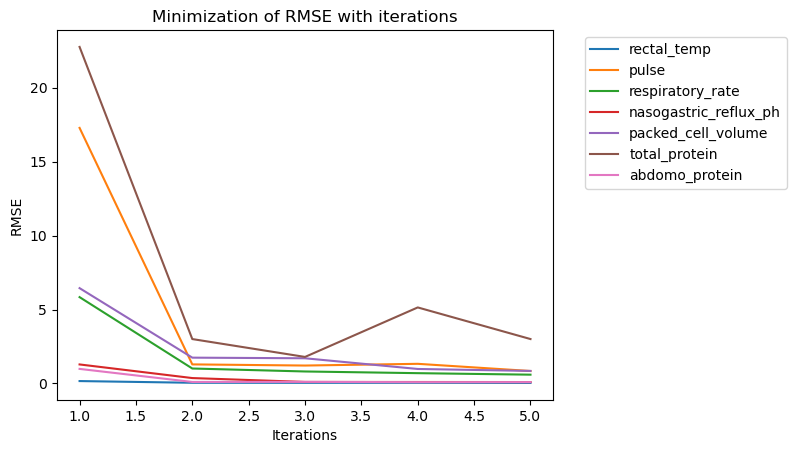

In [41]:
# Function to get RMSE
def rmse(y1,y2):
    return(np.sqrt(mean_squared_error(y1,y2)))

# Function to impute missing numerical features
def fill_missing_numerical(train, test, target, max_iterations=10):
    train_temp=train.copy()
    if target in train_temp.columns:
        train_temp=train_temp.drop(columns=target)
        
    df=pd.concat([train_temp,test],axis="rows")
    df=df.reset_index(drop=True)
    
    missing_num_features = [f for f in df.columns if df[f].dtype != "O" and df[f].isna().any()]

    # Step 1: Store the instances with missing values in each feature
    missing_rows = get_missing_rows(df, missing_num_features)
    
    # Step 2: Initially fill all missing values with "Missing"
    for f in missing_num_features:
        df[f]=df[f].fillna(df[f].mean())
    
    cat_features=[f for f in df.columns if not pd.api.types.is_numeric_dtype(df[f])]
    dictionary = {feature: [] for feature in missing_num_features}
    
    for iteration in tqdm(range(max_iterations), desc="Iterations"):
        for feature in missing_num_features:
            # Skip features with no missing values
            rows_miss = missing_rows[feature].index
            
            missing_temp = df.loc[rows_miss].copy()
            non_missing_temp = df.drop(index=rows_miss).copy()
            y_pred_prev=missing_temp[feature]
            missing_temp = missing_temp.drop(columns=[feature])
            
            # Step 3: Use the remaining features to predict missing values using Random Forests
            X_train = non_missing_temp.drop(columns=[feature])
            y_train = non_missing_temp[[feature]]
            
            catboost_classifier = CatBoostRegressor(**cb_reg_params)
            catboost_classifier.fit(X_train, y_train,cat_features=cat_features, verbose=False)
            
            # Step 4: Predict missing values for the feature and update all N features
            y_pred = catboost_classifier.predict(missing_temp)
            df.loc[rows_miss, feature] = y_pred
            error_minimize=rmse(y_pred,y_pred_prev)
            dictionary[feature].append(error_minimize)  # Append the error_minimize value

    for feature, values in dictionary.items():
        iterations = range(1, len(values) + 1)  # x-axis values (iterations)
        plt.plot(iterations, values, label=feature)  # plot the values
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title('Minimization of RMSE with iterations')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    train[missing_num_features] = np.array(df.iloc[:train.shape[0]][missing_num_features])
    test[missing_num_features] = np.array(df.iloc[train.shape[0]:][missing_num_features])

    return train,test

train_imp, test_imp = fill_missing_numerical(train_imp, test_imp, "outcome", 5)

In [ ]:
# Save imputed data to avoid reiterating it every time
# train_imp.to_csv('train_imp2.csv', index=True)
# test_imp.to_csv('test_imp2.csv', index=True)

# train_imp = pd.read_csv('train_imp2.csv')
# test_imp = pd.read_csv('test_imp2.csv')
# train_imp = train_imp.drop('Unnamed: 0', axis=1)
# test_imp = test_imp.drop('Unnamed: 0', axis=1)

## 4.4. Resolve feature discrepancies in train and test data

In [ ]:
# Drop some less significant features
columns_to_drop = [
    'synthetic', 'peristalsis', 'capillary_refill_time', 'abdomo_protein'
]

# Drop columns from both train and test data
train_imp = train_imp.drop(columns=columns_to_drop, axis=1)
test_imp = test_imp.drop(columns=columns_to_drop, axis=1)

In [283]:
# Map 'outcome' to numerical value
target_map = {
    "lived": 0,
    "died": 1,
    "euthanized": 2
}  

# Create training and test datasets for model prediction
X_train = train_imp.drop(['outcome'], axis=1).reset_index(drop=True)
Y_train = train_imp['outcome'].replace(target_map).reset_index(drop=True)
X_test = test_imp.reset_index(drop=True)
Y_test = sample_data.replace(target_map).reset_index(drop=True).drop("id",axis=1).values.ravel()

C:\Users\Ryzen\AppData\Local\Temp\ipykernel_6200\739825083.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = train_imp['outcome'].replace(target_map).reset_index(drop=True)
C:\Users\Ryzen\AppData\Local\Temp\ipykernel_6200\739825083.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_test = sample_data.replace(target_map).reset_index(drop=True).drop("id",axis=1).values.ravel()


In [284]:
# Change all object type to category type in train and test
for col in X_train.columns:
    if X_train[col].dtype == object:
        X_train[col] = X_train[col].astype('category')

for col in X_test.columns:
    if X_test[col].dtype == object:
        X_test[col] = X_test[col].astype('category')

In [285]:
# Remove unique 'hospital_number' values present in test data but not in train data
missing_hospital_number = [record for record in X_test['hospital_number'] if record not in X_train['hospital_number'].values]
idxs = X_test[X_test['hospital_number'].isin(missing_hospital_number)].index.tolist()
X_test.loc[idxs, 'hospital_number'] = 0

In [286]:
# Change 'hospital_number' to a categorical feature
X_train['hospital_number'] = X_train['hospital_number'].astype('category')
X_test['hospital_number'] = X_test['hospital_number'].astype('category')

## 4.5. Encode categorical features in train and test data

We need to encode some of our categorical features to be used in our models.

We will perform Binary Encoding for 'hospital_number' and One Hot Encoding for the rest of the categorical features

In [287]:
# Binary Encoding for 'hospital_number'
binary_encoder = ce.BinaryEncoder(cols=['hospital_number'])

# Apply Binary Encoding to the 'hospital_number' column in the train and test sets
X_train_binary = binary_encoder.fit_transform(X_train[['hospital_number']])
X_test_binary = binary_encoder.transform(X_test[['hospital_number']])

X_train = pd.concat([X_train_binary, X_train.drop('hospital_number', axis=1)], axis=1)
X_test = pd.concat([X_test_binary, X_test.drop('hospital_number', axis=1)], axis=1)

In [288]:
# One Hot Encoding for categorical features
OHE = OneHotEncoder(drop = 'first')
cat_features = get_cat_features(X_train)
OHE.fit(pd.concat([X_train, X_test.loc[idxs[0]]], axis=0)[cat_features])

# Apply One Hot Encoding to the categorical features in the train and test sets
X_train_cat_OHE = pd.DataFrame(OHE.transform(X_train[cat_features]).toarray(), columns = OHE.get_feature_names_out(input_features=cat_features))
X_train_num = X_train[[col for col in X_train.columns if col not in cat_features]]

X_test_cat_OHE = pd.DataFrame(OHE.transform(X_test[cat_features]).toarray(), columns = OHE.get_feature_names_out(input_features=cat_features))
X_test_num = X_test[[col for col in X_test.columns if col not in cat_features]]

X_train_encoded = pd.concat([X_train_cat_OHE, X_train_num], axis=1)
X_test_encoded = pd.concat([X_test_cat_OHE, X_test_num], axis=1)

In [289]:
# Standardization for numerical features
scaler = StandardScaler()
X_train_encoded_std = X_train_encoded.copy()
X_test_encoded_std = X_test_encoded.copy()

num_features = get_num_features(X_train_encoded_std)
scaler.fit(X_train_encoded_std[num_features])

# Apply standardization to the numerical features in the train and test sets
X_train_encoded_std[num_features] = scaler.transform(X_train_encoded_std[num_features])
X_test_encoded_std[num_features] = scaler.transform(X_test_encoded_std[num_features])

# 5. Ensemble Stacking

## 5.1. Train Base Models

1. Linear Model
- Logistic Regression
- SGDClassifier

2. Tree-Based Model
- Decision Tree Classifier
- Random Forest Classifier
- Gradient Boosting Machines (GBM)
    - XGBoost
    - LightGBM
    - CatBoost
- AdaBoost Classifier
- ExtraTreesClassifier

3. Neural Networks
MLP (Multi-Layer Perceptron)

4. K-Nearest Neighbors (KNN)
KNeighborsClassifier

In [290]:
# Parameters for our models
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction

In [291]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, proba = True, params=None):
        self.clf = clf(**params)
        self.proba = proba
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [292]:
# Function to perform out-of-fold prediction
def get_oof(clf, x_train, y_train, x_test, n_folds=NFOLDS):
    # Initialize out-of-fold arrays
    oof_train = np.zeros(x_train.shape[0])
    oof_test = np.zeros(x_test.shape[0])
    oof_test_skf = np.empty((n_folds, x_test.shape[0]))

    # Cross-validation loop
    for i, (train_index, val_index) in enumerate(KFold(n_splits = NFOLDS).split(x_train, y_train)):
        x_tr, y_tr = x_train.iloc[train_index], y_train.iloc[train_index]
        x_val = x_train.iloc[val_index]

        # Fit the model and predict for validation set
        clf.fit(x_tr, y_tr)
        y_pred = clf.predict(x_val)

        # Store the out-of-fold predictions
        oof_train[val_index] = y_pred.ravel()

        # Predict for the test set and store results for ensemble voting
        oof_test_skf[i, :] = clf.predict(x_test).ravel()

    # Calculate the most frequent class from predictions across all folds (mode)
    oof_test = mode(oof_test_skf, axis=0)[0].ravel()

    # Return the out-of-fold predictions for train and test
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [293]:
# Dictionary of our model name, model and parameters
model_info = [

    ('logreg', LogisticRegression, {
        'max_iter': 1000
    }),

    ('sgd', SGDClassifier, {
        'max_iter': 500
    }),
    
    ('dt', DecisionTreeClassifier, {
        'criterion': 'entropy', 
        'max_depth': 5,
        'min_samples_split': 4,
        'min_samples_leaf': 2,
        'max_features': 'sqrt'
    }),
    
    ('rf', RandomForestClassifier, {
        'n_estimators': 300, 
        'max_depth': 50
    }),
    
    ('xgb', xgb.XGBClassifier, {
        'eval_metric': 'mlogloss', 
        'n_estimators': 500,
        'max_depth': 7,
        'enable_categorical': True,
        'tree_method': 'hist',
        'objective': 'binary:logistic'
    }),
    
    ('lgb', lgb.LGBMClassifier, {
        'n_estimators': 500,
        'max_depth': 7,
        'learning_rate': 0.05,
        'subsample': 0.20,
        'colsample_bytree': 0.56,
        'reg_alpha': 0.25,
        'reg_lambda': 5e-08,
        'boosting_type': 'gbdt'
    }),
    
    ('catboost', CatBoostClassifier, {
        'iterations': 500,
        'depth': 7,
        'learning_rate': 0.1,
        'l2_leaf_reg': 0.7,
        'random_strength': 0.2,
        'max_bin': 200,
        'od_wait': 65,
        'one_hot_max_size': 70,
        'grow_policy': 'Depthwise',
        'bootstrap_type': 'Bayesian',
        'od_type': 'Iter',
        'loss_function': 'MultiClass',
        'verbose': False,
        'cat_features': get_cat_features(X_train)
    }),
    
    ('adaboost', AdaBoostClassifier, {
        'n_estimators': 500
    }),
    
    ('extratrees', ExtraTreesClassifier, {
        'n_estimators': 300, 
        'max_depth': 50
    }),
    
    ('hgb', GradientBoostingClassifier, {
        'n_estimators': 400, 
        'max_depth': 6
    }),
    
    ('mlp', MLPClassifier, {
        'hidden_layer_sizes': (100,), 
        'max_iter': 600
    }),
    
    ('knn', KNeighborsClassifier, {
        'n_neighbors': 30
    })
]

In [294]:
# Function to create the base models for stacking
def create_base_models(model_info, proba):
    base_models = []

    # Loop through each model information
    for model_name, model_clf, model_param in model_info:

        # Create the SklearnHelper instance
        model_helper = SklearnHelper(clf=model_clf, seed=SEED, proba=proba, params=model_param)
        
        # Append the model_helper instance to the base_models list
        base_models.append((f"{model_name}_clf", model_helper))

    return base_models

In [295]:
# Function to create the out-of-fold predictions for our base models
def create_oof(base_models):

    oof_train_list = []
    oof_test_list = []

    for model_name, model in base_models:
        if model_name in {'logreg_clf', 'mlp_clf', 'gpc_clf'}:
            oof_train, oof_test = get_oof(model, X_train_encoded_std, Y_train, X_test_encoded_std)
        elif model_name in {'xgb_clf', 'lgb_clf', 'catboost_clf'}:
            oof_train, oof_test = get_oof(model, X_train, Y_train, X_test)
        else:
            oof_train, oof_test = get_oof(model, X_train_encoded, Y_train, X_test_encoded)

        oof_train_list.append(oof_train)
        oof_test_list.append(oof_test)

        print(model_name + " completed")

    print("Training is complete")

    return oof_train_list, oof_test_list

In [296]:
base_models = create_base_models(model_info, False)

In [298]:
oof_train, oof_test = create_oof(base_models)

logreg_clf completed
sgd_clf completed
dt_clf completed
rf_clf completed
xgb_clf completed
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

c:\Users\Ryzen\anaconda3\envs\catboost_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Ryzen\anaconda3\envs\catboost_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Ryzen\anaconda3\envs\catboost_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Ryzen\anaconda3\envs\catboost_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

adaboost_clf completed
extratrees_clf completed
hgb_clf completed
mlp_clf completed
knn_clf completed
Training is complete


In [299]:
# Stack our predictions
x_train_final = np.stack(oof_train, axis=-1)
x_test_final = np.stack(oof_test, axis=-1)

In [300]:
# Restructure data for inputing to our meta model
x_train_final = x_train_final.reshape(x_train_final.shape[0], -1)
x_test_final = x_test_final.reshape(x_test_final.shape[0], -1)

## 5.2. Train Meta-Model

In [301]:
# Define meta-model (Extra Trees)
meta_model = ExtraTreesClassifier(
    n_estimators=400,
    max_depth=8,
    random_state=42).fit(x_train_final, Y_train)

In [302]:
# Make predictions on the test set
y_pred = meta_model.predict(x_test_final)

# Compute the accuracy
accuracy = accuracy_score(Y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8847


## 5.3. Hyperparameter tuning

In [303]:
clf_list = {
    "logreg", "sgd", "dt", "rf", "xgb", "lgb", "catboost", "adaboost", "extratrees", "hgb", "mlp", "knn"
}

We will make use of Optuna to perform hyperparameter tuning for our models

In [304]:
def objective(trial):
    
    # # Select classifier from the base models - do this manually
    # clf = trial.suggest_categorical("classifier", ["logreg"
    #     # "logreg", "sgd", "dt", "rf", "xgb", "lgb", "catboost", 
    #     # "adaboost", "extratrees", "hgb", "mlp", "knn"
    # ])

    if clf == "logreg":
        param = {
            "C": trial.suggest_float("C", 1e-5, 1e5, log=True),
            "solver": trial.suggest_categorical("solver", ["newton-cg", "sag", "saga", "lbfgs"]),
            "max_iter": trial.suggest_int("max_iter", 500, 5000)
        }
        model = LogisticRegression(**param)

    elif clf == "sgd":
        param = {
            "loss": trial.suggest_categorical("loss", ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"]),
            "penalty": trial.suggest_categorical("penalty", ["elasticnet", "l1", "l2"]),
            "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
            "max_iter": trial.suggest_int("max_iter", 500, 5000, step=500),
        }
        if param["penalty"] == "elasticnet":
            param["l1_ratio"] = trial.suggest_float("l1_ratio", 0, 1)
        model = SGDClassifier(**param)
    
    elif clf == "dt":
        param = {
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        }
        model = DecisionTreeClassifier(**param)

    elif clf == "rf":
        param = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
        }
        if param["bootstrap"] == True:
            param["oob_score"] = trial.suggest_categorical("oob_score", [True, False])
        model = RandomForestClassifier(**param)

    elif clf == "xgb":
        param = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
            "gamma": trial.suggest_float("gamma", 0, 1),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
            "subsample": trial.suggest_float("subsample", 0.5, 1),
            # Fixed parameters
            'eval_metric': 'mlogloss', 
            'enable_categorical': True,
            'objective': 'multi:softmax',
            'early_stopping_rounds': 100
        }
        model = xgb.XGBClassifier(**param)

    elif clf == "lgb":
        param = {
            "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "rf"]),
            "num_leaves": trial.suggest_int("num_leaves", 10, 30),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1),
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "subsample ": trial.suggest_float("subsample", 0.5, 1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
            "reg_lambda ": trial.suggest_float("reg_lambda", 0, 1),
            # Fixed parameters
            'metric': 'multi_error', 
            'objective': 'multiclass',
            'early_stopping_rounds': 100,
            'verbose': 0
        }
        model = lgb.LGBMClassifier(**param)

    elif clf == "catboost":
        param = {
            "iterations": trial.suggest_int("iterations", 50, 500),
            "depth": trial.suggest_int("depth", 3, 10),            
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.01, 0.1),
            "max_bin": trial.suggest_int("max_bin", 1, 255),
            "random_strength": trial.suggest_float("random_strength", 0.01, 0.1),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
            "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            # Fixed parameters
            'cat_features': get_cat_features(X_train), 
            'loss_function':'MultiClass',
            'eval_metric': 'MultiClass',
            'early_stopping_rounds': 100,
            'verbose': 0
        }
        if param["bootstrap_type"] == "Bayesian":
            param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif param["bootstrap_type"] == "Bernoulli":
            param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        model = CatBoostClassifier(**param)

    elif clf == "adaboost":
        param = {
            "n_estimators": trial.suggest_int("n_estimators", 10, 500),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1)
        }
        model = AdaBoostClassifier(**param)

    elif clf == "extratrees":
        param = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
            "max_depth": trial.suggest_int("max_depth", 3, 40),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.1, 0.5, 0.8]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
        }
        if param["bootstrap"] == True:
            param["oob_score"] = trial.suggest_categorical("oob_score", [True, False])
        model = ExtraTreesClassifier(**param)

    elif clf == "hgb":
        param = {
            "loss": trial.suggest_categorical("loss", ["log_loss"]),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1),
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "criterion": trial.suggest_categorical("criterion", ["friedman_mse", "squared_error"]),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),            
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.1, 0.5, 0.8]),
        }
        model = GradientBoostingClassifier(**param)

    elif clf == "mlp":
        param = {
            "hidden_layer_sizes": trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (100, 50), (100, 100), (50, 100), (200, 100)]),
            "solver": trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"]),
            "alpha": trial.suggest_float("alpha", 1e-5, 1.0),
            "max_iter": trial.suggest_int("max_iter", 200, 1000),

        }
        if param["solver"] == "sgd":
            param["learning_rate"] = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
            param["learning_rate_init"] = trial.suggest_float("learning_rate_init", 1e-5, 1.0)
            param["power_t"] = trial.suggest_float("power_t", 0.1, 1.0)
        elif param["solver"] == "adam":
            param["learning_rate_init"] = trial.suggest_float("learning_rate_init", 1e-5, 1.0)
            param["beta_1"] = trial.suggest_float("beta_1", 0.7, 0.95)
            param["beta_2"] = trial.suggest_float("beta_2", 0.8, 0.999)
            param["epsilon"] = trial.suggest_float("epsilon", 1e-8, 1e-2)
        model = MLPClassifier(**param)

    elif clf == "knn":
        param = {
            "n_neighbors": trial.suggest_int("n_neighbors", 2, 100),
            "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            "algorithm": trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
            "p": trial.suggest_int("p", 1, 2)
        }
        model = KNeighborsClassifier(**param)
    
    if clf in {'logreg', 'mlp'}:
        X = X_train_encoded_std
    elif clf in {'xgb', 'lgb', 'catboost'}:
        X = X_train
    else:
        X = X_train_encoded

    if clf in {'xgb', 'lgb', 'catboost'}:
        train_x, valid_x, train_y, valid_y = train_test_split(X, Y_train, test_size=0.3)
        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)])
        preds = model.predict(valid_x)
        pred_labels = np.rint(preds)
        accuracy = accuracy_score(valid_y, pred_labels)
        return accuracy
    else:
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold Stratified Cross-Validation
        cv_scores = cross_val_score(model, X, Y_train, cv=cv, scoring="accuracy")

        # Return the mean of the cross-validation scores
        return np.mean(cv_scores)

In [305]:
best_params_dict = {}

for x in clf_list:
    clf = x

    if __name__ == "__main__":
        # Create study and optimize
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=100)

        # Print best trial
        print("Best trial:")
        trial = study.best_trial
        print("  Value: {}".format(trial.value))
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        # Optionally, you can save the best parameters for each model to a dictionary
        for trial in study.trials:
            classifier_name = trial.params.get('classifier')
            best_params_dict[classifier_name] = trial.params

print("\nBest parameters for each classifier:")
for classifier_name, params in best_params_dict.items():
    print(f"{classifier_name}: {params}")

[I 2024-11-19 21:52:15,554] A new study created in memory with name: no-name-7b14e014-c769-4ff6-a785-8bfb0fc100ea
[I 2024-11-19 21:52:15,713] Trial 0 finished with value: 0.6560088593576966 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2}. Best is trial 0 with value: 0.6560088593576966.
[I 2024-11-19 21:52:15,804] Trial 1 finished with value: 0.6965847176079734 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'algorithm': 'brute', 'p': 2}. Best is trial 1 with value: 0.6965847176079734.
[I 2024-11-19 21:52:15,930] Trial 2 finished with value: 0.6546777408637874 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'algorithm': 'brute', 'p': 1}. Best is trial 1 with value: 0.6965847176079734.
[I 2024-11-19 21:52:16,063] Trial 3 finished with value: 0.6513532668881507 and parameters: {'n_neighbors': 82, 'weights': 'uniform', 'algorithm': 'brute', 'p': 1}. Best is trial 1 with value: 0.6965847176079734.
[I 2024-11-19 21:52:16,129] Trial 

KeyboardInterrupt: 

In [ ]:
# Function to update our model dictionary with the new parameters
def update_model_params(model_info, best_params_dict):
    # Iterate over the model_info list
    for i, (model_name, model_class, params) in enumerate(model_info):
        # Check if the model_name exists in best_params_dict
        if model_name in best_params_dict:
            # Get the updated parameters from best_params_dict, excluding 'classifier' key
            updated_params = {key: value for key, value in best_params_dict[model_name].items() if key != 'classifier'}

            # # Special handling for XGBoost to add 'enable_categorical'
            if model_name == 'xgb':
                updated_params['enable_categorical'] = True

            # # Special handling for CatBoost to add 'cat_features'
            if model_name == 'catboost':
                updated_params['cat_features'] = get_cat_features(X_train)
                
            # Update the parameters in model_info with the filtered best_params_dict values
            model_info[i] = (model_name, model_class, updated_params)

    return model_info

In [ ]:
tuned_model_info = update_model_params(model_info.copy(), best_params_dict)

# Print the updated model_info to see the changes
for model_name, model_class, params in tuned_model_info:
    print(f"Model: {model_name}, Parameters: {params}")

Model: logreg, Parameters: {'max_iter': 1000}
Model: sgd, Parameters: {'max_iter': 500}
Model: dt, Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Model: rf, Parameters: {'n_estimators': 300, 'max_depth': 50}
Model: xgb, Parameters: {'eval_metric': 'mlogloss', 'n_estimators': 500, 'max_depth': 7, 'enable_categorical': True, 'tree_method': 'hist', 'objective': 'binary:logistic'}
Model: lgb, Parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.2, 'colsample_bytree': 0.56, 'reg_alpha': 0.25, 'reg_lambda': 5e-08, 'boosting_type': 'gbdt'}
Model: catboost, Parameters: {'iterations': 500, 'depth': 7, 'learning_rate': 0.1, 'l2_leaf_reg': 0.7, 'random_strength': 0.2, 'max_bin': 200, 'od_wait': 65, 'one_hot_max_size': 70, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'od_type': 'Iter', 'loss_function': 'MultiClass', 'verbose': False, 'cat_features': ['surgery', 'age', 'temp_

In [ ]:
# Best trial:
#   Value: 0.731889258028793
#   Params: 
#     classifier: logreg
#     C: 0.039924696005081105
#     solver: sag
#     max_iter: 4791

# Best parameters for each classifier:
# logreg: {'classifier': 'logreg', 'C': 44220.52176567629, 'solver': 'sag', 'max_iter': 4364}


# Best trial:
#   Value: 0.620093023255814
#   Params: 
#     classifier: sgd
#     loss: log_loss
#     penalty: l1
#     alpha: 0.05643595867011764
#     max_iter: 3000

# Best parameters for each classifier:
# sgd: {'classifier': 'sgd', 'loss': 'perceptron', 'penalty': 'l1', 'alpha': 0.01709916290079802, 'max_iter': 2500}


# Best trial:
#   Value: 0.6799601328903654
#   Params: 
#     classifier: dt
#     criterion: gini
#     splitter: best
#     max_depth: 10
#     min_samples_split: 7
#     min_samples_leaf: 5
#     max_features: sqrt

# Best parameters for each classifier:
# dt: {'classifier': 'dt', 'criterion': 'entropy', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}


# Best trial:
#   Value: 0.7504939091915837
#   Params: 
#     classifier: rf
#     n_estimators: 153
#     criterion: gini
#     max_depth: 14
#     min_samples_split: 5
#     min_samples_leaf: 1
#     max_features: sqrt
#     bootstrap: False

# Best parameters for each classifier:
# rf: {'classifier': 'rf', 'n_estimators': 266, 'criterion': 'gini', 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}


# Best trial:
#   Value: 0.7849223946784922
#   Params: 
#     classifier: xgb
#     n_estimators: 206
#     max_depth: 6
#     booster: gbtree
#     colsample_bylevel: 0.9352084607570419
#     colsample_bytree: 0.6306035310788768
#     gamma: 0.4203043182775335
#     learning_rate: 0.026212742128016744
#     reg_alpha: 0.9107671080487685
#     reg_lambda: 0.506540050878807
#     subsample: 0.8738506613934287

# Best parameters for each classifier:
# xgb: {'classifier': 'xgb', 'n_estimators': 212, 'max_depth': 7, 'booster': 'gbtree', 'colsample_bylevel': 0.9554600866321016, 'colsample_bytree': 0.5300271398869442, 'gamma': 0.39009647661017427, 'learning_rate': 0.01814051128931882, 'reg_alpha': 0.7421246030896591, 'reg_lambda': 0.5270151191813004, 'subsample': 0.8367196388185355}


# Best trial:
#   Value: 0.7915742793791575
#   Params: 
#     classifier: lgb
#     boosting_type: gbdt
#     num_leaves: 20
#     max_depth: 10
#     learning_rate: 0.037681807133923335
#     n_estimators: 179
#     subsample: 0.6896709787592985
#     colsample_bytree: 0.6094198795314275
#     reg_alpha: 0.5281569446658979
#     reg_lambda: 0.34223826340771146

# Best parameters for each classifier:
# lgb: {'classifier': 'lgb', 'boosting_type': 'gbdt', 'num_leaves': 20, 'max_depth': 10, 'learning_rate': 0.037681807133923335, 'n_estimators': 179, 'subsample': 0.6896709787592985, 'colsample_bytree': 0.6094198795314275, 'reg_alpha': 0.5281569446658979, 'reg_lambda': 0.34223826340771146}


# Best trial:
#   Value: 0.7871396895787139
#   Params: 
#     classifier: catboost
#     iterations: 125
#     depth: 6
#     learning_rate: 0.10538557295669396
#     l2_leaf_reg: 0.0572190909416846
#     max_bin: 219
#     random_strength: 0.09971940650876912
#     boosting_type: Plain
#     bootstrap_type: Bernoulli
#     subsample: 0.32655172599330445

# Best parameters for each classifier:
# catboost: {'classifier': 'catboost', 'iterations': 227, 'depth': 6, 'learning_rate': 0.6021056692020845, 'l2_leaf_reg': 0.08396584347981637, 'max_bin': 227, 'random_strength': 0.06392346433469036, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7134942185105512}


# Best trial:
#   Value: 0.7245669988925802
#   Params: 
#     classifier: adaboost
#     n_estimators: 494
#     learning_rate: 0.08587844369574378

# Best parameters for each classifier:
# adaboost: {'classifier': 'adaboost', 'n_estimators': 211, 'learning_rate': 0.9364465574197355}


# Best trial:
#   Value: 0.7511627906976744
#   Params: 
#     classifier: extratrees
#     n_estimators: 880
#     criterion: entropy
#     max_depth: 38
#     min_samples_split: 3
#     min_samples_leaf: 1
#     max_features: 0.1
#     bootstrap: True
#     oob_score: True

# Best parameters for each classifier:
# extratrees: {'classifier': 'extratrees', 'n_estimators': 791, 'criterion': 'entropy', 'max_depth': 33, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.1, 'bootstrap': True, 'oob_score': True}


# Best trial:
#   Value: 0.7551605758582502
#   Params: 
#     classifier: hgb
#     loss: log_loss
#     learning_rate: 0.027088428196290544
#     n_estimators: 185
#     subsample: 0.9604519736140806
#     criterion: squared_error
#     min_samples_split: 5
#     min_samples_leaf: 7
#     max_depth: 8
#     max_features: sqrt

# Best parameters for each classifier:
# hgb: {'classifier': 'hgb', 'loss': 'log_loss', 'learning_rate': 0.005266899532136408, 'n_estimators': 499, 'subsample': 0.8863210692444734, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 7, 'max_features': 'sqrt'}


# Best trial:
#   Value: 0.7418582502768549
#   Params: 
#     classifier: mlp
#     hidden_layer_sizes: (100,)
#     solver: sgd
#     alpha: 0.6228250353968035
#     max_iter: 937
#     learning_rate: constant
#     learning_rate_init: 0.0018819883776458254
#     power_t: 0.1797114818000257

# Best parameters for each classifier:
# mlp: {'classifier': 'mlp', 'hidden_layer_sizes': (100,), 'solver': 'sgd', 'alpha': 0.7659235980019393, 'max_iter': 419, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0008997402449588695, 'power_t': 0.8932536134464413}


# Best trial:
#   Value: 0.7092292358803987
#   Params: 
#     classifier: knn
#     n_neighbors: 13
#     weights: distance
#     algorithm: auto
#     p: 1

# Best parameters for each classifier:
# knn: {'classifier': 'knn', 'n_neighbors': 12, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 1}

In [ ]:
base_models = create_base_models(tuned_model_info, False)

oof_train, oof_test = create_oof(base_models)

x_train_final_tuned = np.stack(oof_train, axis=-1)
x_test_final_tuned = np.stack(oof_test, axis=-1)

x_train_final_tuned = x_train_final_tuned.reshape(x_train_final_tuned.shape[0], -1)
x_test_final_tuned = x_test_final_tuned.reshape(x_test_final_tuned.shape[0], -1)

logreg_clf completed
sgd_clf completed
dt_clf completed
rf_clf completed
xgb_clf completed
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

c:\Users\Ryzen\anaconda3\envs\catboost_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Ryzen\anaconda3\envs\catboost_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Ryzen\anaconda3\envs\catboost_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Ryzen\anaconda3\envs\catboost_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

adaboost_clf completed
extratrees_clf completed
hgb_clf completed


c:\Users\Ryzen\anaconda3\envs\catboost_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


mlp_clf completed
knn_clf completed
Training is complete


We will now tune the meta model as well

In [ ]:
def objective_meta(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        # Fixed parameters
        'eval_metric': 'mlogloss', 
        'enable_categorical': True,
        'objective': 'multi:softmax',
        'early_stopping_rounds': 100
    }
    model = xgb.XGBClassifier(**param)

    train_x, valid_x, train_y, valid_y = train_test_split(x_train_final, Y_train, test_size=0.3)
    model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)])
    preds = model.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

In [308]:
if __name__ == "__main__":
    # Create study and optimize
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_meta, n_trials=100)

    # Print best trial
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

[I 2024-11-19 21:53:24,589] A new study created in memory with name: no-name-9271a85f-eb71-4ada-9d29-ff26958d8e28
[I 2024-11-19 21:53:26,051] Trial 0 finished with value: 0.7538361018826135 and parameters: {'n_estimators': 380, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.7538361018826135.
[I 2024-11-19 21:53:27,316] Trial 1 finished with value: 0.7505160575858251 and parameters: {'n_estimators': 388, 'criterion': 'log_loss', 'max_depth': 34, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 0.1, 'bootstrap': False}. Best is trial 0 with value: 0.7538361018826135.
[I 2024-11-19 21:53:32,834] Trial 2 finished with value: 0.7498516057585826 and parameters: {'n_estimators': 948, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 0.1, 'bootstrap': True, 'oob_score': True}. Best is trial 0 with value: 0.7538361018

Best trial:
  Value: 0.7571627906976744
  Params: 
    n_estimators: 66
    criterion: log_loss
    max_depth: 29
    min_samples_split: 3
    min_samples_leaf: 9
    max_features: sqrt
    bootstrap: False


In [ ]:
# Best trial:
#   Value: 0.7849223946784922
#   Params: 
#     classifier: xgb
#     n_estimators: 206
#     max_depth: 6
#     booster: gbtree
#     gamma: 0.4203043182775335
#     learning_rate: 0.026212742128016744
#     reg_alpha: 0.9107671080487685
#     reg_lambda: 0.506540050878807
#     subsample: 0.8738506613934287

meta_model = xgb.XGBClassifier(
    booster='gbtree',
    use_label_encoder=False, 
    eval_metric='mlogloss', 
    random_state=42,
    max_depth=6,
    learning_rate=0.026212742128016744,
    enable_categorical=True,
    tree_method="hist",
    objective='binary:logistic',
    n_estimators=206,
    gamma= 0.4203043182775335,
    reg_alpha= 0.9107671080487685,
    reg_lambda= 0.506540050878807,
    subsample= 0.8738506613934287
    ).fit(x_train_final, Y_train)

c:\Users\Ryzen\anaconda3\envs\catboost_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:15:10] WARNING: D:\bld\xgboost-split_1730232589250\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [432]:
# Make predictions on the test set
y_pred2 = meta_model.predict(x_test_final_tuned)

# Compute the accuracy
accuracy = accuracy_score(Y_test, y_pred2)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9053


In [433]:
# Create submision.csv
answers = sample_data.copy()
answers['outcome'] = y_pred2.copy()
answers['outcome'] = answers['outcome'].replace({v:k for k,v in target_map.items()})
answers.to_csv('kaggle_submission.csv', index=False)